# Project Details:

* Title: 
* Team Members:

# Introduction

The **Reboot: Box-Plots for Education** is a data science challenge sponsored by the Education Resource Strategies (ERS). It is an on-going competition which will end in February. 

In this project, we plan to solve a **multi-class-multi-label classification problem** with the goal of attaching canonical labels to the freeform text in budget line items. These labels let ERS understand how schools are spending money and tailor their strategy recommendations to improve outcomes for students, teachers, and administrators.




# ETL Phase

## Prepare the notebook

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import check_array
from time import time

%matplotlib inline

In [10]:
%ls -l data/education_reboot/TrainingData.csv

Invalid switch - "education_reboot".


In [11]:
path = os.path.join('data','education_reboot') #make sure you have the same path in your parent directory
path

'data\\education_reboot'

In [12]:
def load_data(datapath,data):
    csv_path = os.path.join(datapath,data)
    df = pd.read_csv(csv_path,index_col=0)
    print(df.info())
    display(df.head())
    print()
    return df

In [13]:
train = load_data(path,"TrainingData.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


Looking at the column names i.e. our features, we see there are **Two** numeric features, FTE and TOTAL.

* FTE stands for full-time equivalent(0-100%). To elaborate, if a budget item is associated to an employee, then we have a value between 0 and 1. It tells us the percentage of full-time that the employee works. A value of 1 means the employee works full-time. A value close to 0 means the employee is working either part-time or on contract basis.

* TOTAL stands for the total cost of the expenditure. It tells us how much the budget item costs.

**Let's explore them further:**

In [14]:
train.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


We see there are some negative values in the the numeric features. We would have to impute such missing or incorrect values as we cannot have a negative value associated with the percentage of full-time that the employee works or total cost of the expenditure.

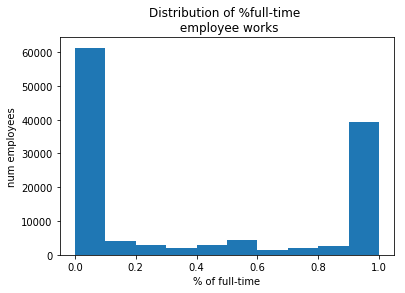

In [15]:
plt.hist(train['FTE'].dropna(),range=[0,1])
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.show()

From the above plot, we can see that our budgets data favors part-time and contract-based employees as we have more contract employees than full-time employees. 

We can assume that contract-based employees are hired for a short-term purpose and that is why they need certain items more frequent than full-time employees who would have such items easily accessible. (NEED to INFER something!)

Converting our Categorical columns datatype from object to categorical, as this will help in the future for pipeline

In [16]:
cat_list = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type',
              'Pre_K','Operating_Status']

In [17]:
cat_lab = lambda x: x.astype('category')

train[cat_list] = train[cat_list].apply(cat_lab,axis=0)

print(train.dtypes)

Function                  category
Use                       category
Sharing                   category
Reporting                 category
Student_Type              category
Position_Type             category
Object_Type               category
Pre_K                     category
Operating_Status          category
Object_Description          object
Text_2                      object
SubFund_Description         object
Job_Title_Description       object
Text_3                      object
Text_4                      object
Sub_Object_Description      object
Location_Description        object
FTE                        float64
Function_Description        object
Facility_or_Department      object
Position_Extra              object
Total                      float64
Program_Description         object
Fund_Description            object
Text_1                      object
dtype: object


In [18]:
np.round(np.sum(train['Total'] < 0)/np.sum(train['Total']),6)

8e-06

Look's good

**Let's see the sub-categories of our target classes**

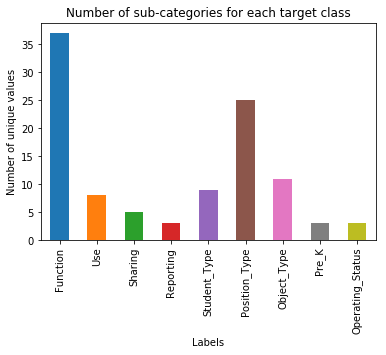

In [19]:
import matplotlib.pyplot as plt

uni_labels = train[cat_list].apply(pd.Series.nunique)

uni_labels.plot(kind='bar')

plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.title('Number of sub-categories for each target class')

plt.show()

# Numeric pipeline 

In [20]:
num_lab = ['FTE','Total']
numeric_train = train[num_lab].fillna(-1000)

In [21]:
#create dummies of our targets
dummies_lab = pd.get_dummies(train[cat_list])

In [22]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_train,dummies_lab,
                                                               size=0.2,seed=143)

NameError: name 'multilabel_train_test_split' is not defined

In [ ]:
np.sum(X_train.isna())

In [ ]:
y_train.info()

In [ ]:
train.info() #Int64Index: 400277 entries, 134338 to 415831

In [ ]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
#fit_x = log_model.fit(X_train,y_train)

# Classifier training


## Driven Data classifier

In [ ]:
#Try correlation
#from pandas.plotting import scatter_matrix

# Top three correlated inputs with housing_median_age
#attributes = ["Survived", "Fare", "Pclass", "Parch", "Age"]
#scatter_matrix(data[attributes], figsize=(12, 8));

In [51]:
#source: https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])


## Trials with predicting accuracy for One Label at a time

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [24]:
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                      [df[col] for col in cols])

In [25]:
train["all"] = str_join(train, " ", 'FTE', 'Facility_or_Department', 'Function_Description', 'Fund_Description','Job_Title_Description', 'Location_Description', 'Object_Description','Position_Extra', 'Program_Description', 'SubFund_Description', 'Sub_Object_Description','Text_1', 'Text_2', 'Text_3', 'Text_4' )

In [26]:
train['all'].head()

134338    1.0 nan nan General Fund Teacher-Elementary  n...
206341    nan nan RGN  GOB nan (blank) nan CONTRACTOR SE...
326408    1.0 nan nan General Purpose School TCHER 2ND G...
364634    nan nan UNALLOC BUDGETS/SCHOOLS nan Teacher, S...
47683     nan nan NON-PROJECT nan Teacher, Secondary (Hi...
Name: all, dtype: object

In [27]:
# split data into a trainin set (70%), validation set (15%) and blind (holdout) test set (15%)
df_train, df_other = train_test_split(train, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_other, test_size=0.5, random_state=42)

### Using OneVsRestClassifier - MultinomialNB

In [28]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [29]:
NB_pipeline.fit(df_train['all'], df_train['Function'])

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...assifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1))])

In [33]:
prediction = NB_pipeline.predict(df_val['all'])
print('Test accuracy is {}'.format( accuracy_score(df_val['Function'], prediction)))

Prediction ['Teacher Compensation' 'Student Transportation' 'Student Transportation'
 ... 'Instructional Materials & Supplies'
 'Instructional Materials & Supplies' 'Aides Compensation'] :Test accuracy is 0.8249225542120515


In [31]:
prediction

array(['Teacher Compensation', 'Student Transportation',
       'Student Transportation', ...,
       'Instructional Materials & Supplies',
       'Instructional Materials & Supplies', 'Aides Compensation'],
      dtype='<U47')

### Accuracy for all categories

In [35]:
for category in cat_list:
    NB_pipeline.fit(df_train['all'], df_train[category])
    prediction = NB_pipeline.predict(df_val['all'])
    print('Category {} : Test accuracy is {}'.format(category, accuracy_score(df_val[category], prediction)))

Category Function : Test accuracy is 0.8249225542120515
Category Use : Test accuracy is 0.8738882782052563
Category Sharing : Test accuracy is 0.8583991206155691
Category Reporting : Test accuracy is 0.8861297092035575
Category Student_Type : Test accuracy is 0.889577295892875
Category Position_Type : Test accuracy is 0.8710402718097332
Category Object_Type : Test accuracy is 0.8906931814396589
Category Pre_K : Test accuracy is 0.96595716331901
Category Operating_Status : Test accuracy is 0.9561473635122081


### Using OneVsRestClassifier - Logistic Regression

In [36]:
LR_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

In [ ]:
for category in cat_list:
    LR_pipeline.fit(df_train['all'], df_train[category])
    prediction = LR_pipeline.predict(df_val['all'])
    print('Category {} : Test accuracy is {}'.format(category, accuracy_score(df_val[category], prediction)))

Category Function : Test accuracy is 0.9400419706205656
Category Use : Test accuracy is 0.9499517004763333
Category Sharing : Test accuracy is 0.9532493920922022
Category Reporting : Test accuracy is 0.9671230138902768
Category Student_Type : Test accuracy is 0.9657073381965957
Category Position_Type : Test accuracy is 0.9726524765997135
